In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np
from math import log
from CIoTS import *
import json
from time import time
import random

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
runs = 5
p_range = [5, 10, 15, 20] 
dimensions = 3
data_length = 10000
alpha = 0.05
in_edges_range = [2, 4]
auto_corr = 0.75
patience = 2*max(p_range)
p_max = 2*max(p_range)

In [114]:
############## Iterative #######################

# with open('results/edge_deletion_pc1_maxcond5.json', 'r') as f:
#     results = json.load(f)
with open('results/edge_deletion_pc1.json', 'r') as f:
    results = json.load(f)

settings = []
true_graphs = []
pred_graphs_it = []
times_it = []
sepsets_it = []
cond_sizes_it = []

for setting in results:
    for experiment in setting['experiments']:
        settings.append((setting['in_edges'], setting['dim'], setting['p']))
        
        cond_sizes_it.append(experiment['cond_sizes'])
        true_graph = nx.from_dict_of_lists(experiment['true_graph'], nx.DiGraph())
        
#         closest_idx = min(setting['p']-1, len(experiment['iterations'])-1)
#         pred_graph = nx.from_dict_of_lists(experiment['iterations'][closest_idx]['graph'], nx.DiGraph())
#         pred_p = experiment['iterations'][closest_idx]['p_iter']
#         print('{} vs. real {}'.format(pred_p, setting['p']))
        
        pred_graph = nx.from_dict_of_lists(experiment['iterations'][setting['p']-1]['graph'], nx.DiGraph())
        pred_p = experiment['iterations'][setting['p']-1]['p_iter']
        assert pred_p == setting['p']
        
        assert len(experiment['iterations'][:setting['p']]) == setting['p']
        time = sum([e['time'] for e in experiment['iterations'][:setting['p']]])
        times_it.append(time)
        
        true_graphs.append(true_graph)
        pred_graphs_it.append(pred_graph)
        sepsets_it.append(experiment['sepsets'])

        
############## Non-iterative ###################        

with open('results/edge_deletion_pc1_noniterative.json', 'r') as f:
    results = json.load(f)

pred_graphs_nonit = []
times_nonit = []
sepsets_nonit = []
cond_sizes_nonit = []

for setting in results:
    for experiment in setting['experiments']:
        true_graph = nx.from_dict_of_lists(experiment['true_graph'], nx.DiGraph())
        pred_graph = nx.from_dict_of_lists(experiment['iterations'][0]['graph'], nx.DiGraph())
        pred_p = experiment['iterations'][0]['p_iter']
        assert pred_p == setting['p']
        assert nx.is_isomorphic(true_graph, true_graphs[len(pred_graphs_nonit)])
        
        time = experiment['iterations'][0]['time']
        times_nonit.append(time)
        pred_graphs_nonit.append(pred_graph)
        sepsets_nonit.append(experiment['sepsets'])
        cond_sizes_nonit.append(experiment['cond_sizes'])
        
grouped_settings = sorted(list(set(settings)))

### Compare specific iteration

In [59]:
desired_p = lambda p: 2*p

############## Iterative #######################

# with open('results/edge_deletion_pc1_maxcond5.json', 'r') as f:
#     results = json.load(f)
with open('results/edge_deletion_pc1.json', 'r') as f:
    results = json.load(f)

settings = []
true_graphs = []
pred_graphs_it = []
times_it = []
sepsets_it = []
cond_sizes_it = []

for setting in results:
    for experiment in setting['experiments']:
        settings.append((setting['in_edges'], setting['dim'], setting['p']))
        
        cond_sizes_it.append(experiment['cond_sizes'])
        sepsets_it.append(experiment['sepsets'])
        true_graph = nx.from_dict_of_lists(experiment['true_graph'], nx.DiGraph())
        true_graphs.append(true_graph)
        
        for index, iteration in enumerate(experiment['iterations']):
            if iteration['p_iter'] == desired_p(setting['p']):
                pred_graph = nx.from_dict_of_lists(iteration['graph'], nx.DiGraph())
                pred_graphs_it.append(pred_graph)

                assert len(experiment['iterations'][:index+1]) == desired_p(setting['p'])
                time = sum([e['time'] for e in experiment['iterations'][:index+1]])
                times_it.append(time)
                break

        
############## Non-iterative ###################        

with open('results/edge_deletion_pc1_noniterative.json', 'r') as f:
    results = json.load(f)

pred_graphs_nonit = []
times_nonit = []
sepsets_nonit = []
cond_sizes_nonit = []

for setting in results:
    for experiment in setting['experiments']:
        true_graph = nx.from_dict_of_lists(experiment['true_graph'], nx.DiGraph())
        assert nx.is_isomorphic(true_graph, true_graphs[len(pred_graphs_nonit)])
        
        sepsets_nonit.append(experiment['sepsets'])
        cond_sizes_nonit.append(experiment['cond_sizes'])
        
        for index, iteration in enumerate(experiment['iterations']):
            if iteration['p_iter'] == desired_p(setting['p']):
                pred_graph = nx.from_dict_of_lists(iteration['graph'], nx.DiGraph())
                pred_graphs_nonit.append(pred_graph)

                time = sum([e['time'] for e in experiment['iterations'][:index+1]])
                times_nonit.append(time)
                break
        
grouped_settings = sorted(list(set(settings)))

In [91]:
def plot_errorbarchart(index, a, b, title='scores iterative vs. non-iterative PC1'):
    fig, ax = plt.subplots(figsize=(20,10))

    ind = np.arange(len(index))
    width = 0.35
    p1 = ax.bar(ind, np.mean(a, axis=1), width, color='r', bottom=0, yerr=np.std(a, axis=1))

    p2 = ax.bar(ind + width, np.mean(b, axis=1), width, color='y', bottom=0, yerr=np.std(b, axis=1))

    ax.set_title(title)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(index)

    ax.legend((p1[0], p2[0]), ('Iterative', 'Non-iterative'))
    ax.autoscale_view()

    plt.show()

### Compare VAR models based on graph

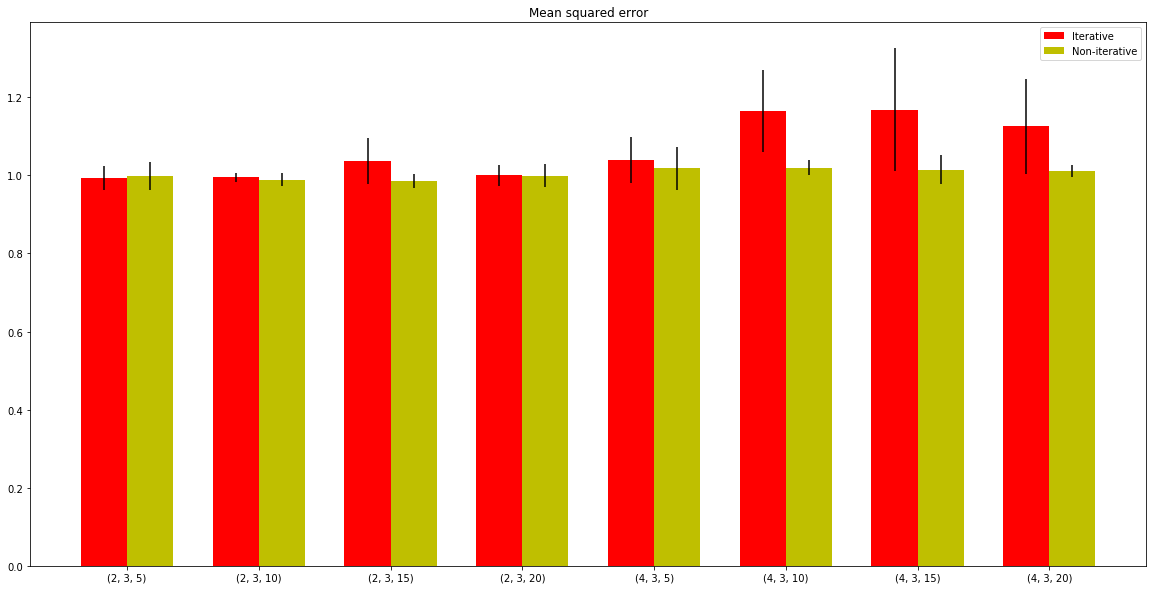

In [115]:
mses_it = []
mses_nonit = []
mses_var = []

for i in range(40):
    ts = pd.read_csv('results/' + datasets[i])
#     print(len(ts))
    train_data, test_data = ts[:8000], ts[8000:]
    node_mapping, data_matrix = transform_ts(train_data, settings[i][2])
    
    var_model = VAR(settings[i][2])
    var_model.fit(train_data)
    mse, bic = var_model.evaluate_test_set(train_data[-settings[i][2]:], test_data)
    mses_var.append(mse)

    it_var_model = VAR(settings[i][2])
    it_var_model.fit_from_graph(settings[i][1], data_matrix, pred_graphs_it[i], node_mapping)
    mse, bic = it_var_model.evaluate_test_set(train_data[-settings[i][2]:], test_data)
    mses_it.append(mse)

    nonit_var_model = VAR(settings[i][2])
    nonit_var_model.fit_from_graph(settings[i][1], data_matrix, pred_graphs_nonit[i], node_mapping)
    mse, bic = nonit_var_model.evaluate_test_set(train_data[-settings[i][2]:], test_data)
    mses_nonit.append(mse)
    
mses_it = np.reshape(mses_it, (len(grouped_settings), 5))
mses_nonit = np.reshape(mses_nonit, (len(grouped_settings), 5))
mses_var = np.reshape(mses_var, (len(grouped_settings), 5))

plot_errorbarchart(grouped_settings, mses_it, mses_nonit, 'Mean squared error')

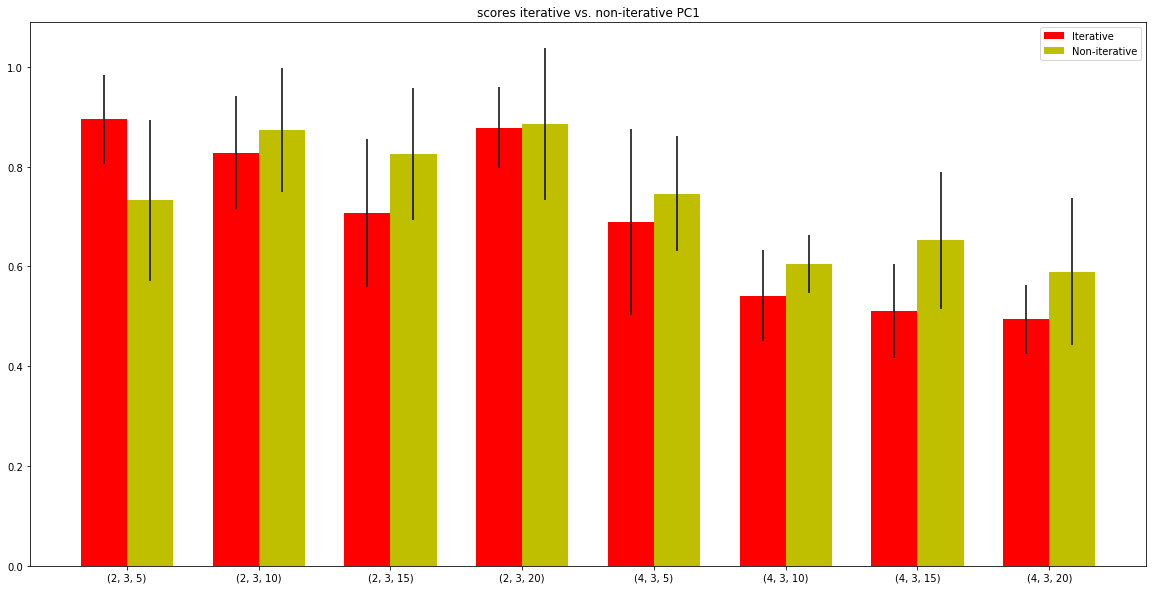

In [116]:
f1_it = [evaluate_edges(true_g, pred_g)['f1-score'] for true_g, pred_g in zip(true_graphs, pred_graphs_it)]
f1_it = np.reshape(f1_it, (len(grouped_settings), 5))

f1_nonit = [evaluate_edges(true_g, pred_g)['f1-score'] for true_g, pred_g in zip(true_graphs, pred_graphs_nonit)]
f1_nonit = np.reshape(f1_nonit, (len(grouped_settings), 5))

plot_errorbarchart(grouped_settings, f1_it, f1_nonit)

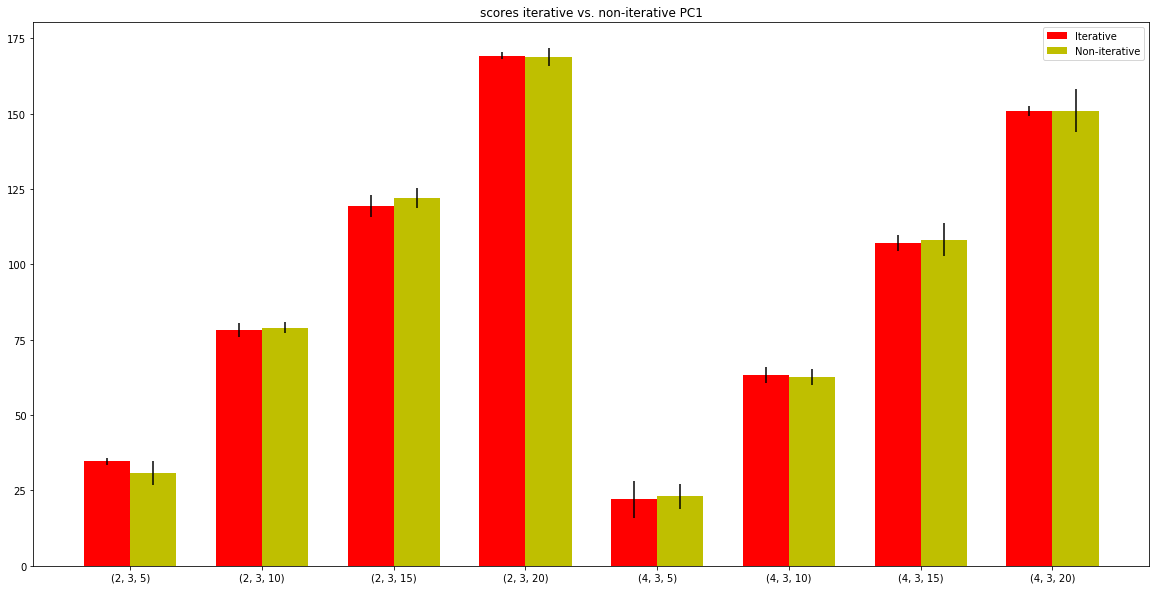

In [117]:
tn_it = []
for setting, true_g, pred_g in zip(settings, true_graphs, pred_graphs_it):
    p_iter, dim = setting[2], setting[1]
    confusion, _ = evaluate_edge_deletion(true_g, [{'p_iter': p_iter, 'graph': pred_g}], dim)
    tn_it.append(confusion['tn'][0])
tn_it = np.reshape(tn_it, (len(grouped_settings), 5))
    
tn_nonit = []
for setting, true_g, pred_g in zip(settings, true_graphs, pred_graphs_nonit):
    p_iter, dim = setting[2], setting[1]
    confusion, _ = evaluate_edge_deletion(true_g, [{'p_iter': p_iter, 'graph': pred_g}], dim)
    tn_nonit.append(confusion['tn'][0])
tn_nonit = np.reshape(tn_nonit, (len(grouped_settings), 5))

plot_errorbarchart(grouped_settings, tn_it, tn_nonit)

In [21]:
np.mean(tn_it, axis=1) - np.mean(tn_nonit, axis=1)

array([ -1.8,  -8.8, -17.2,  -2.4, -12.2, -26.4, -45. , -55. ])

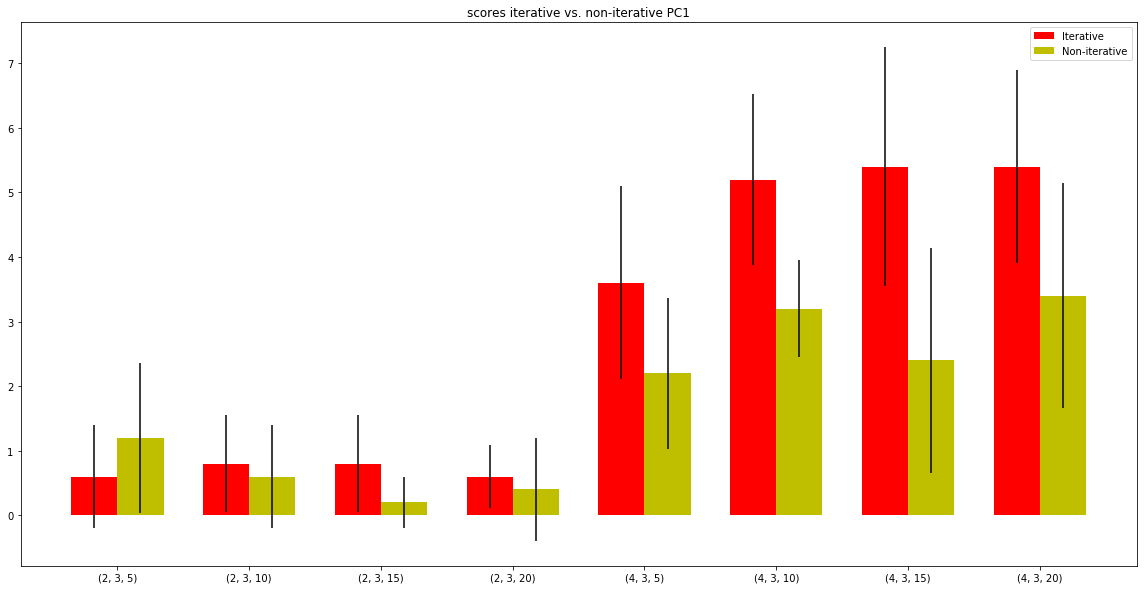

In [118]:
# False negatives
fn_it = []
for setting, true_g, pred_g in zip(settings, true_graphs, pred_graphs_it):
    p_iter, dim = setting[2], setting[1]
    confusion, _ = evaluate_edge_deletion(true_g, [{'p_iter': p_iter, 'graph': pred_g}], dim)
    fn_it.append(confusion['fn'][0])
fn_it = np.reshape(fn_it, (len(grouped_settings), 5))
    
fn_nonit = []
for setting, true_g, pred_g in zip(settings, true_graphs, pred_graphs_nonit):
    p_iter, dim = setting[2], setting[1]
    confusion, _ = evaluate_edge_deletion(true_g, [{'p_iter': p_iter, 'graph': pred_g}], dim)
    fn_nonit.append(confusion['fn'][0])
fn_nonit = np.reshape(fn_nonit, (len(grouped_settings), 5))

plot_errorbarchart(grouped_settings, fn_it, fn_nonit)

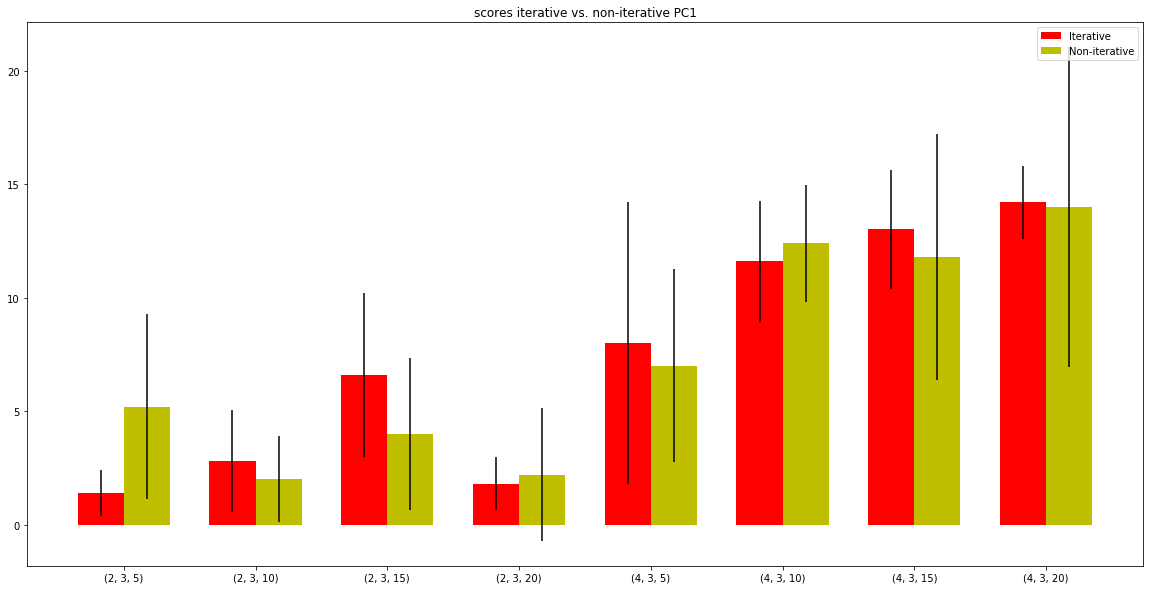

In [119]:
# False positive
fp_it = []
for setting, true_g, pred_g in zip(settings, true_graphs, pred_graphs_it):
    p_iter, dim = setting[2], setting[1]
    confusion, _ = evaluate_edge_deletion(true_g, [{'p_iter': p_iter, 'graph': pred_g}], dim)
    fp_it.append(confusion['fp'][0])
fp_it = np.reshape(fp_it, (len(grouped_settings), 5))
    
fp_nonit = []
for setting, true_g, pred_g in zip(settings, true_graphs, pred_graphs_nonit):
    p_iter, dim = setting[2], setting[1]
    confusion, _ = evaluate_edge_deletion(true_g, [{'p_iter': p_iter, 'graph': pred_g}], dim)
    fp_nonit.append(confusion['fp'][0])
fp_nonit = np.reshape(fp_nonit, (len(grouped_settings), 5))

plot_errorbarchart(grouped_settings, fp_it, fp_nonit)

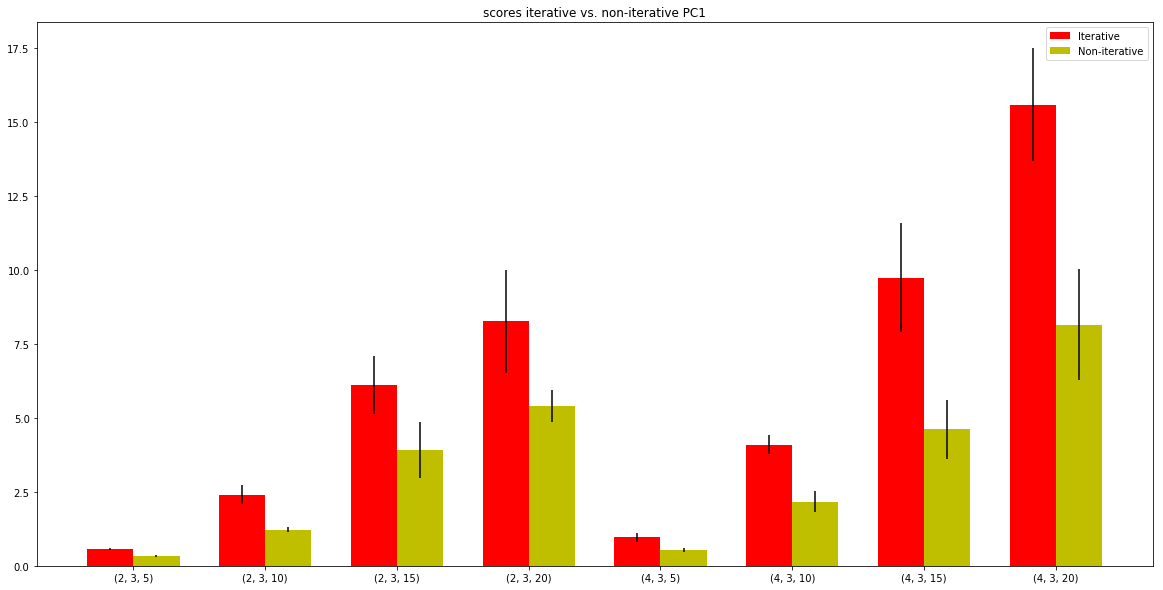

In [120]:
times_it2 = np.reshape(times_it, (len(grouped_settings), 5))
times_nonit2 = np.reshape(times_nonit, (len(grouped_settings), 5))

plot_errorbarchart(grouped_settings, times_it2, times_nonit2)

In [12]:
def transform_to_full_graph(true_graph):
    full_graph = true_graph.copy()
    current_edges = list(full_graph.edges())
    for from_node, to_node in current_edges:
        from_dim, from_p = node_id(from_node)
        to_dim, to_p = node_id(to_node)

        for j in range(1, settings[i][2] - from_p + 1):
            new_from = node_name(from_dim, from_p+j)
            new_to = node_name(to_dim, to_p+j)
            full_graph.add_edge(new_from, new_to)
    return full_graph

(2, 3, 15)


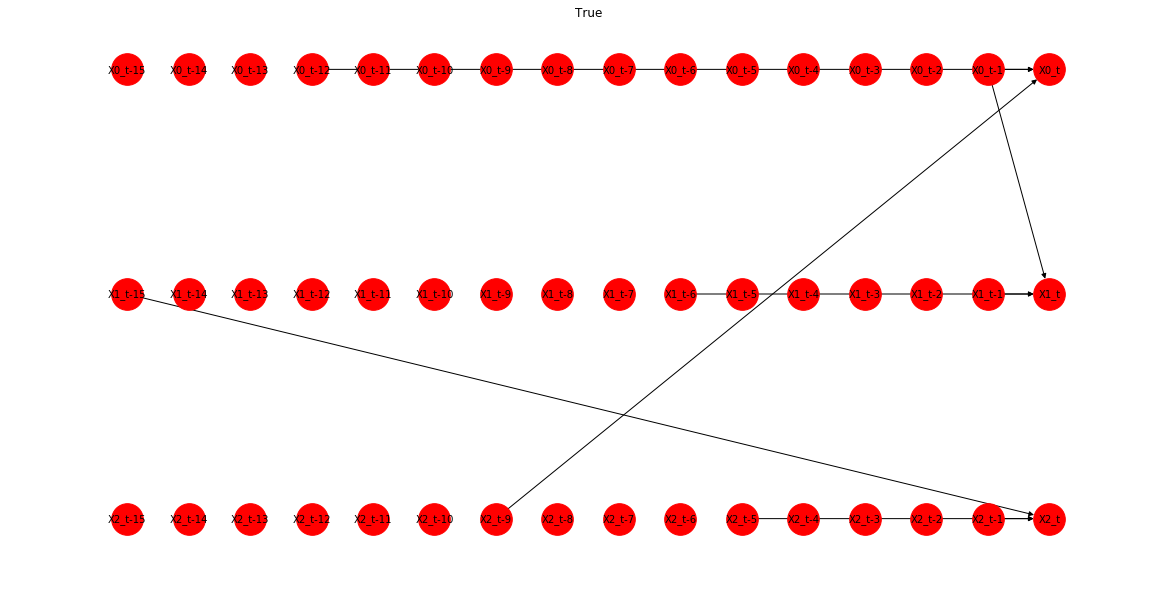

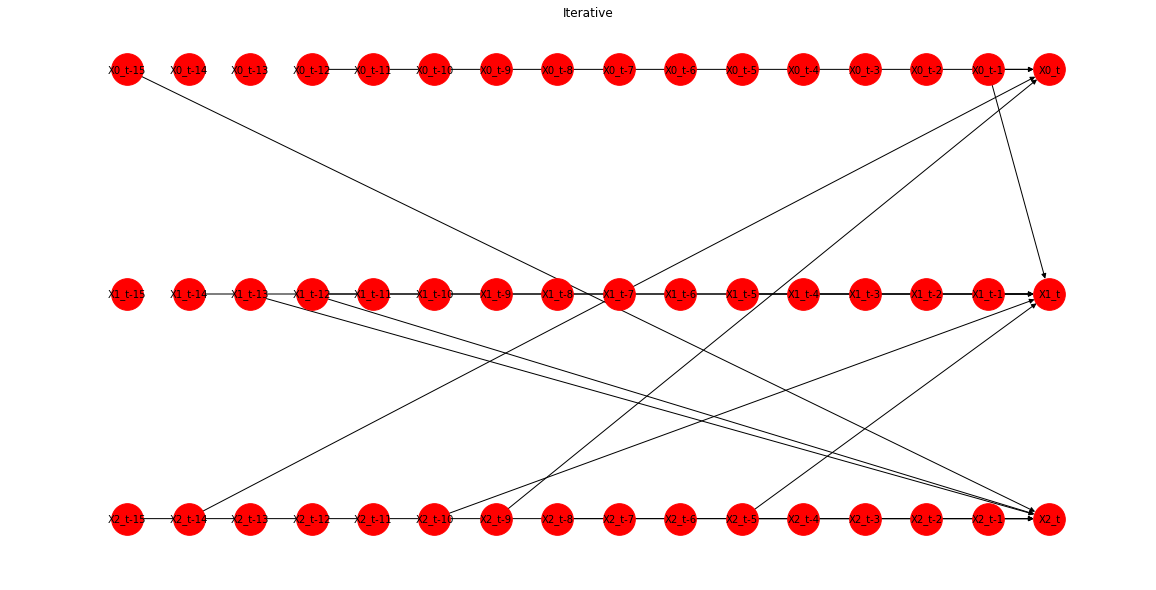

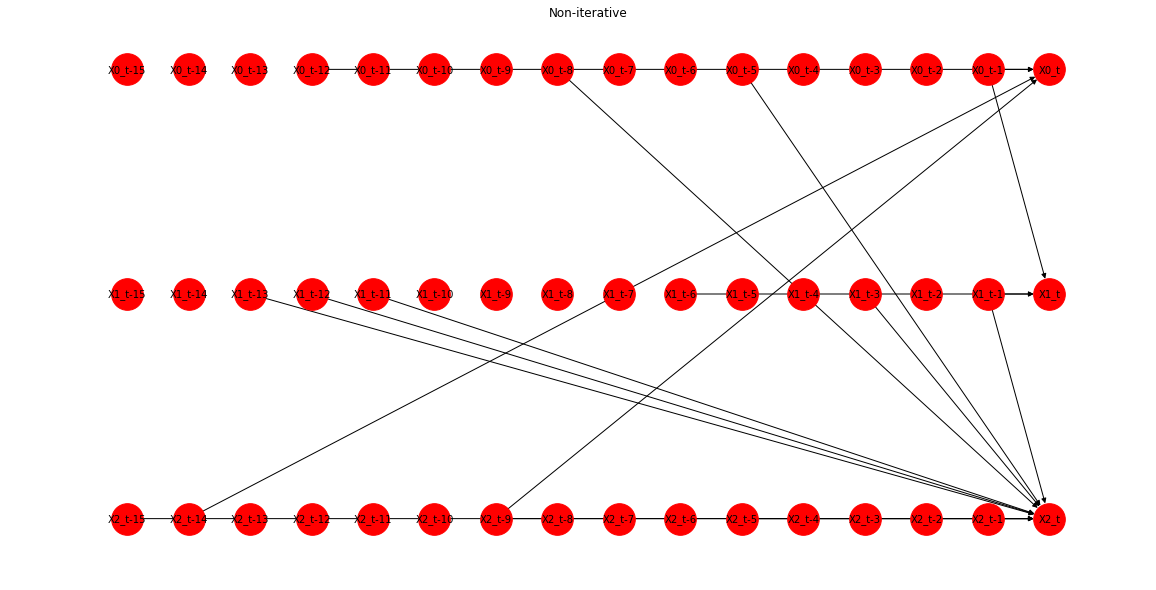

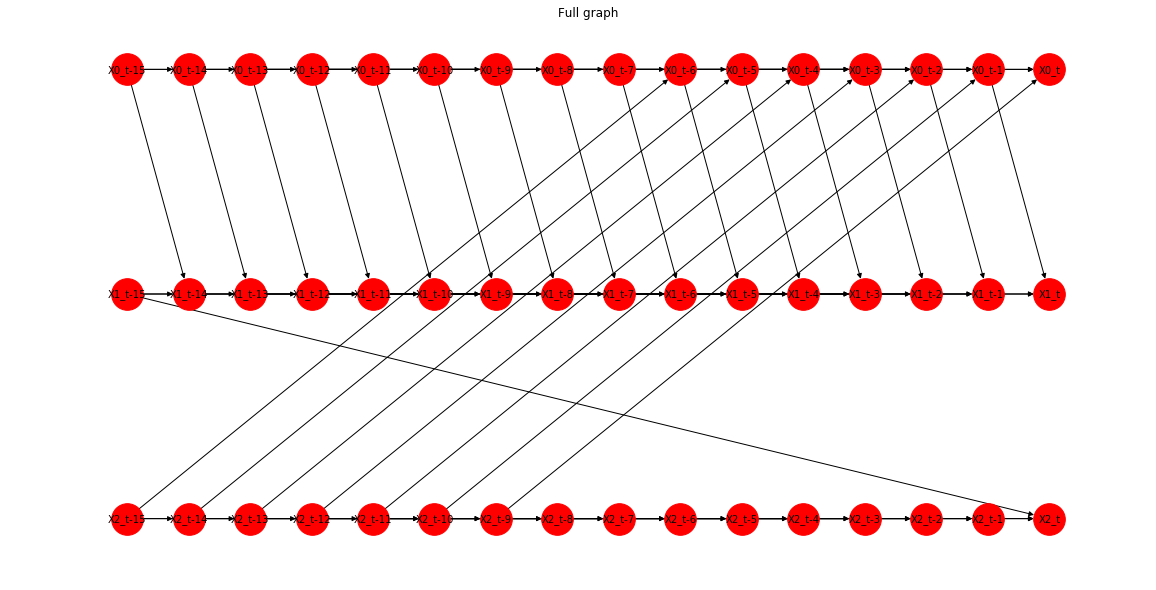

In [83]:
i = 12
print(settings[i])

plt.figure(figsize=(20,10))
plt.title('True')
draw_graph(true_graphs[i], settings[i][1], settings[i][2])
plt.figure(figsize=(20,10))
plt.title('Iterative')
draw_graph(pred_graphs_it[i], settings[i][1], settings[i][2])
plt.figure(figsize=(20,10))
plt.title('Non-iterative')
draw_graph(pred_graphs_nonit[i], settings[i][1], settings[i][2])
plt.figure(figsize=(20,10))
plt.title('Full graph')
draw_graph(transform_to_full_graph(true_graphs[i]), settings[i][1], settings[i][2])

In [82]:
from functools import reduce

with open('results/edge_deletion.json', 'r') as f:
    old_results = json.load(f)

datasets = reduce(lambda a,b:a+b, [[experiment['data'] for experiment in setting['experiments']] for setting in old_results])

In [15]:
fn_it.flatten()[i]

2

In [26]:
for i in range(40):
    print(i)
    print('Non-iterative vs. iterative')
    print('{} vs. {}'.format(cond_sizes_nonit[i][0], np.max(np.array(cond_sizes_it[i][:settings[i][2]]), axis=0)))
    print('False negatives: {} vs. {}'.format(fn_nonit.flatten()[i], fn_it.flatten()[i]))

0
Non-iterative vs. iterative
[6, 7, 5] vs. [5 7 5]
False negatives: 3 vs. 1
1
Non-iterative vs. iterative
[4, 6, 4] vs. [4 6 5]
False negatives: 0 vs. 0
2
Non-iterative vs. iterative
[3, 4, 8] vs. [3 7 6]
False negatives: 1 vs. 0
3
Non-iterative vs. iterative
[5, 8, 2] vs. [6 7 2]
False negatives: 2 vs. 2
4
Non-iterative vs. iterative
[6, 4, 4] vs. [5 4 6]
False negatives: 0 vs. 0
5
Non-iterative vs. iterative
[6, 4, 5] vs. [ 5  4 10]
False negatives: 2 vs. 1
6
Non-iterative vs. iterative
[3, 4, 6] vs. [5 7 8]
False negatives: 1 vs. 1
7
Non-iterative vs. iterative
[4, 6, 4] vs. [5 9 5]
False negatives: 0 vs. 0
8
Non-iterative vs. iterative
[4, 4, 6] vs. [ 5  8 10]
False negatives: 0 vs. 0
9
Non-iterative vs. iterative
[4, 4, 5] vs. [7 5 7]
False negatives: 0 vs. 2
10
Non-iterative vs. iterative
[8, 8, 12] vs. [ 6 11  7]
False negatives: 0 vs. 0
11
Non-iterative vs. iterative
[6, 5, 5] vs. [ 5  5 10]
False negatives: 0 vs. 0
12
Non-iterative vs. iterative
[6, 14, 12] vs. [ 9 10  8]
Fal

In [17]:
for i in range(40):
    ts = pd.read_csv('results/' + datasets[i])
    node_mapping, data_matrix = transform_ts(ts, settings[i][2])
    nm = dict([(v,k) for k,v in node_mapping.items()])

    t_g = set(true_graphs[i].edges())
    p_g_it = set(pred_graphs_it[i].edges())
    p_g_nonit = set(pred_graphs_nonit[i].edges())
    fns = t_g - p_g_it - (t_g - p_g_nonit)

    print('{}: {} false negatives'.format(settings[i], len(fns)))
    for from_fn, to_fn in fns:
            sepset = [e['sepset'] for e in sepsets_it[i] if e['from'] == from_fn and e['to'] == to_fn][0]
            p_value, statistic = partial_corr_test(data_matrix, nm[from_fn], nm[to_fn], 
                                                   [nm[e] for e in sepset])
            true_parents = list(true_graphs[i].predecessors(to_fn))
            full_graph = transform_to_full_graph(true_graphs[i])
            all_paths = [set(e) for e in nx.all_simple_paths(full_graph, from_fn, to_fn)]
            neither_path_nor_parent = [s for s in sepset if not any([s in p for p in all_paths]) and s not in true_parents]
            
            print('From {} to {}'.format(from_fn, to_fn))
            print('Sepset: {}'.format(sepset))
            print('P value {}, statistic {}'.format(p_value, statistic))
            print('Real parents of {}: {}'.format(to_fn, true_parents))
            print('Non-parent conditionals: {}'.format(set(sepset) - set(true_parents)))
            print('Neither in path nor a parent: {}'.format(neither_path_nor_parent))
            print()
#             print('All paths: {}'.format(all_paths))
    print('---------------------------------------------------------')

(2, 3, 5): 0 false negatives
---------------------------------------------------------
(2, 3, 5): 0 false negatives
---------------------------------------------------------
(2, 3, 5): 0 false negatives
---------------------------------------------------------
(2, 3, 5): 0 false negatives
---------------------------------------------------------
(2, 3, 5): 0 false negatives
---------------------------------------------------------
(2, 3, 10): 1 false negatives
From X0_t-5 to X2_t
Sepset: ['X2_t-1', 'X2_t-3', 'X0_t-3', 'X1_t-5', 'X1_t-3', 'X0_t-2', 'X2_t-4', 'X2_t-5', 'X2_t-2']
P value 0.6853205508515146, statistic 0.4052135431021805
Real parents of X2_t: ['X0_t-5', 'X1_t-10', 'X2_t-1']
Non-parent conditionals: {'X0_t-3', 'X0_t-2', 'X1_t-5', 'X2_t-3', 'X2_t-2', 'X2_t-4', 'X1_t-3', 'X2_t-5'}
Neither in path nor a parent: ['X2_t-3', 'X0_t-3', 'X1_t-5', 'X1_t-3', 'X0_t-2', 'X2_t-4', 'X2_t-5', 'X2_t-2']

---------------------------------------------------------
(2, 3, 10): 0 false negatives

(4, 3, 10): 3 false negatives
From X1_t-8 to X1_t
Sepset: ['X1_t-1', 'X0_t-8', 'X2_t-8', 'X0_t-2', 'X0_t-10', 'X1_t-9', 'X2_t-9']
P value 0.21110570911596727, statistic 1.2505308062181852
Real parents of X1_t: ['X0_t-10', 'X1_t-8', 'X1_t-6', 'X1_t-1', 'X2_t-4']
Non-parent conditionals: {'X1_t-9', 'X0_t-2', 'X2_t-8', 'X2_t-9', 'X0_t-8'}
Neither in path nor a parent: ['X0_t-8', 'X2_t-8', 'X0_t-2', 'X1_t-9', 'X2_t-9']

From X1_t-6 to X1_t
Sepset: ['X1_t-1', 'X0_t-2', 'X0_t-9', 'X2_t-8', 'X0_t-10']
P value 0.4152771105789781, statistic 0.8146422643130296
Real parents of X1_t: ['X0_t-10', 'X1_t-8', 'X1_t-6', 'X1_t-1', 'X2_t-4']
Non-parent conditionals: {'X0_t-2', 'X0_t-9', 'X2_t-8'}
Neither in path nor a parent: ['X0_t-2', 'X0_t-9', 'X2_t-8']

From X2_t-4 to X1_t
Sepset: ['X1_t-1', 'X2_t-8', 'X0_t-2', 'X2_t-7', 'X0_t-8', 'X2_t-1']
P value 0.4503090953692095, statistic 0.7548998173876628
Real parents of X1_t: ['X0_t-10', 'X1_t-8', 'X1_t-6', 'X1_t-1', 'X2_t-4']
Non-parent conditionals: {'X2_t

(4, 3, 20): 3 false negatives
From X2_t-14 to X1_t
Sepset: ['X1_t-1', 'X0_t-7', 'X0_t-13', 'X1_t-10', 'X2_t-13', 'X0_t-15', 'X0_t-14', 'X1_t-13', 'X1_t-2']
P value 0.2995514454939733, statistic 1.0373957772862301
Real parents of X1_t: ['X0_t-18', 'X0_t-13', 'X0_t-7', 'X1_t-1', 'X2_t-14']
Non-parent conditionals: {'X2_t-13', 'X0_t-14', 'X0_t-15', 'X1_t-13', 'X1_t-2', 'X1_t-10'}
Neither in path nor a parent: ['X1_t-10', 'X2_t-13', 'X0_t-15', 'X0_t-14', 'X1_t-13', 'X1_t-2']

From X2_t-10 to X2_t
Sepset: ['X2_t-1', 'X2_t-8', 'X2_t-9']
P value 0.16638335720527908, statistic 1.3839186769147194
Real parents of X2_t: ['X0_t-20', 'X1_t-17', 'X1_t-7', 'X2_t-10', 'X2_t-1']
Non-parent conditionals: {'X2_t-9', 'X2_t-8'}
Neither in path nor a parent: []

From X1_t-7 to X2_t
Sepset: ['X2_t-1', 'X1_t-6', 'X2_t-7', 'X2_t-6', 'X0_t-1', 'X2_t-2', 'X2_t-3', 'X1_t-3']
P value 0.4346270354879618, statistic 0.7812983582741517
Real parents of X2_t: ['X0_t-20', 'X1_t-17', 'X1_t-7', 'X2_t-10', 'X2_t-1']
Non-par